In [1]:
import pandas as pd

**Experiment to run**

1. Try increasing the size of the data by augmentation (**Done**)
2. Try sobel's edge detection befor augmentation
3. Use the other columns for soft voting process
4. Transfer learning from vision transformers
5. Need to run for more epochs - Resnet model and I have also used augmentation before training for resnet


Note: Try to clean up the functions especially for the train, valid, and test generator.

In [2]:
import tensorflow as tf
print(tf.__version__)

2024-04-28 04:55:42.200063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 04:55:42.200108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 04:55:42.201540: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:
df = pd.read_csv("/kaggle/input/cv-data/filtered.csv-20240417T033754Z-001/filtered.csv/_SELECT_l_ID_as_library_id_l_name_pl_particle_pi2_image_pp_ch2_c_202404132221.csv")

In [4]:
df.head()

,library_id,name,particle,image,ch2_ch1Ratio,edgeGradient,ratioBlueGreen,ratioRedBlue,ratioRedGreen,fiberCurl,fiberStraightness,geodesicAspectRatio
0,1,10X_FOV 100 Anabaena WILL CRASH,47676.0,C:\sqlite\images\filtered.csv\files\_SELECT_l_...,NaN,118.626556,0.940923,1.072899,1.009515,0.262735,0.791932,0.118967
1,1,10X_FOV 100 Anabaena WILL CRASH,1713447.0,C:\sqlite\images\filtered.csv\files\_SELECT_l_...,0.0,97.245370,1.002229,0.995190,0.997409,0.610796,0.620811,0.073763
2,1,10X_FOV 100 Anabaena WILL CRASH,2643419.0,C:\sqlite\images\filtered.csv\files\_SELECT_l_...,0.0,77.308824,1.001570,0.997306,0.998871,0.433340,0.697671,0.098531
3,1,10X_FOV 100 Anabaena WILL CRASH,2715141.0,C:\sqlite\images\filtered.csv\files\_SELECT_l_...,0.0,74.448276,1.000309,1.000353,1.000661,0.003502,0.996510,0.417987
4,1,10X_FOV 100 Anabaena WILL CRASH,2734501.0,C:\sqlite\images\filtered.csv\files\_SELECT_l_...,0.0,107.162437,1.005026,0.989868,0.994843,0.117837,0.894585,0.162788


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   library_id           3060 non-null   int64  
 1   name                 3060 non-null   object 
 2   particle             3059 non-null   float64
 3   image                3059 non-null   object 
 4   ch2_ch1Ratio         3030 non-null   float64
 5   edgeGradient         3059 non-null   float64
 6   ratioBlueGreen       3059 non-null   float64
 7   ratioRedBlue         3059 non-null   float64
 8   ratioRedGreen        3059 non-null   float64
 9   fiberCurl            3059 non-null   float64
 10  fiberStraightness    3059 non-null   float64
 11  geodesicAspectRatio  3059 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 287.0+ KB


So we can see that the sql dump has 3059 total entries labelled with library_id(which I am assuming is the Algae class label).

In [6]:
df.describe()

,library_id,particle,ch2_ch1Ratio,edgeGradient,ratioBlueGreen,ratioRedBlue,ratioRedGreen,fiberCurl,fiberStraightness,geodesicAspectRatio
count,3060.000000,3.059000e+03,3030.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000
mean,35.708497,2.075216e+06,-0.080193,96.208980,0.924406,1.106211,1.007622,0.480010,0.781587,0.296437
std,31.339216,1.701113e+06,0.593998,34.166168,0.099599,0.152230,0.019662,0.573176,0.254934,0.335431
min,1.000000,4.767600e+04,-5.398100,25.049500,0.553301,0.934438,0.941081,0.000000,0.185295,0.005302
25%,9.000000,5.083850e+04,-0.333153,69.678650,0.859140,0.997412,0.997641,0.060910,0.592224,0.049823
50%,33.000000,2.368664e+06,0.000000,91.272727,0.998982,1.001748,1.000145,0.301795,0.768170,0.141068
75%,48.000000,3.343788e+06,0.230900,117.586800,1.001267,1.186255,1.014315,0.688549,0.942587,0.393004
max,147.000000,7.661887e+06,2.620198,222.485714,1.034556,1.892545,1.105874,4.396804,1.462223,1.000000


In [7]:
category_counts = df['library_id'].value_counts().sort_values(ascending=False)
print(category_counts[:10])

library_id
46    253
53    233
43    177
9     173
12    154
25    142
2     141
44    135
1     121
13     96
Name: count, dtype: int64


from above we can find that we have most images for library_id classes 46,53,43,9 and 12 in top 5. Each of top 5 classes have more than 172 records.

In [8]:
top_5_filtered_df = df[df['library_id'].isin([46,53,43,9,12])]
not_in_top_5_df = df[~df['library_id'].isin([46,53,43,9,12])]

not_in_top_5_df['library_id']=999
not_in_top_5_df['name'] = "Others"

top_5_filtered_df = pd.concat([top_5_filtered_df, not_in_top_5_df])

top_5_filtered_df.reset_index(drop=True, inplace=True)
top_5_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   library_id           3060 non-null   int64  
 1   name                 3060 non-null   object 
 2   particle             3059 non-null   float64
 3   image                3059 non-null   object 
 4   ch2_ch1Ratio         3030 non-null   float64
 5   edgeGradient         3059 non-null   float64
 6   ratioBlueGreen       3059 non-null   float64
 7   ratioRedBlue         3059 non-null   float64
 8   ratioRedGreen        3059 non-null   float64
 9   fiberCurl            3059 non-null   float64
 10  fiberStraightness    3059 non-null   float64
 11  geodesicAspectRatio  3059 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 287.0+ KB


/tmp/ipykernel_134/819404127.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_in_top_5_df['library_id']=999
/tmp/ipykernel_134/819404127.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_in_top_5_df['name'] = "Others"


In [9]:
#removing the row without image path
top_5_filtered_df = top_5_filtered_df.dropna(subset=['image'])
top_5_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3059 entries, 0 to 3059
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   library_id           3059 non-null   int64  
 1   name                 3059 non-null   object 
 2   particle             3059 non-null   float64
 3   image                3059 non-null   object 
 4   ch2_ch1Ratio         3030 non-null   float64
 5   edgeGradient         3059 non-null   float64
 6   ratioBlueGreen       3059 non-null   float64
 7   ratioRedBlue         3059 non-null   float64
 8   ratioRedGreen        3059 non-null   float64
 9   fiberCurl            3059 non-null   float64
 10  fiberStraightness    3059 non-null   float64
 11  geodesicAspectRatio  3059 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 310.7+ KB


In [10]:
unique_values = [46,53,43,9,12,999]
print(unique_values)
result_dict = {}
category_counts = df['library_id'].value_counts().sort_values(ascending=False)

for value in unique_values:
    row_index = top_5_filtered_df[top_5_filtered_df['library_id'] == value].iloc[0]
    print(row_index['name'])
    count = (top_5_filtered_df['library_id'] == value).sum()
    print(count)
#     corresponding_values = top_5_filtered_df.iloc[row_index]
#     result_dict[value] = corresponding_values

print(result_dict)

[46, 53, 43, 9, 12, 999]
Peridinium 10X FOV100
253
Staurastrum 10X FOV 100
233
Ceratium 10X FOV100
177
Example_Cyclotella_10X_TR
173
Example_Microcystis_10X_TR
154
Others
2069
{}


In [11]:
label_dict = {
    46:"Peridinium", 
    53:"Straustrum", 
    43:"Ceratrium", 
    9:"Cyclotella", 
    12:"Microcystis", 
    25:"Pedastrium", 
    2:"Anabaena-coiled", 
    44:"Fragillaria", 
    1:"Anabaena", 
    27: 'Planktothrix', 
    999: 'other' 
}

In [12]:
top_5_filtered_df.describe()

,library_id,particle,ch2_ch1Ratio,edgeGradient,ratioBlueGreen,ratioRedBlue,ratioRedGreen,fiberCurl,fiberStraightness,geodesicAspectRatio
count,3059.000000,3.059000e+03,3030.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000
mean,687.131089,2.075216e+06,-0.080193,96.208980,0.924406,1.106211,1.007622,0.480010,0.781587,0.296437
std,451.040936,1.701113e+06,0.593998,34.166168,0.099599,0.152230,0.019662,0.573176,0.254934,0.335431
min,9.000000,4.767600e+04,-5.398100,25.049500,0.553301,0.934438,0.941081,0.000000,0.185295,0.005302
25%,53.000000,5.083850e+04,-0.333153,69.678650,0.859140,0.997412,0.997641,0.060910,0.592224,0.049823
50%,999.000000,2.368664e+06,0.000000,91.272727,0.998982,1.001748,1.000145,0.301795,0.768170,0.141068
75%,999.000000,3.343788e+06,0.230900,117.586800,1.001267,1.186255,1.014315,0.688549,0.942587,0.393004
max,999.000000,7.661887e+06,2.620198,222.485714,1.034556,1.892545,1.105874,4.396804,1.462223,1.000000


Okay now let's try to see some examples of these images. There is column 'image' representing the path to images.

In [13]:
top_5_filtered_df.iloc[0]

library_id                                                             9
name                                           Example_Cyclotella_10X_TR
particle                                                         50552.0
image                  C:\sqlite\images\filtered.csv\files\_SELECT_l_...
ch2_ch1Ratio                                                     -0.6555
edgeGradient                                                    119.2761
ratioBlueGreen                                                  0.727741
ratioRedBlue                                                    1.458449
ratioRedGreen                                                   1.061374
fiberCurl                                                            0.0
fiberStraightness                                                1.16299
geodesicAspectRatio                                                  1.0
Name: 0, dtype: object

In [14]:
top_5_filtered_df.iloc[0]['image']

'C:\\sqlite\\images\\filtered.csv\\files\\_SELECT_l_ID_as_library_id_l_name_pl_particle_pi2_image_pp_ch2_c_202404132221.csv-599.data'

/content/drive/MyDrive/images/filtered.csv/files/_SELECT_l_ID_as_library_id_l_name_pl_particle_pi2_image_pp_ch2_c_202404132221.csv-599.png

this is sample path in the drive, imported in google colab. We have somehow convert the image path from data to this format.

In [15]:
def convert_path(input_path):
    parts = input_path.split('\\')
    file_name_with_extension = parts[-1]

    file_name_parts = file_name_with_extension.split('.')[:-1]
    file_name = '.'.join(file_name_parts)

    prefix = "/kaggle/input/cv-data/filtered.csv-20240417T033754Z-001/"
    new_path = '/'.join(parts[3:-1]) + '/' + file_name + ".png"
    return prefix + new_path

# input_path = r"C:\sqlite\images\filtered.csv\files\_SELECT_l_ID_as_library_id_l_name_pl_particle_pi2_image_pp_ch2_c_202404132221.csv-599.data"
# output_path = convert_path(input_path)
# print(output_path)


In [16]:
path = convert_path(top_5_filtered_df.iloc[158]['image'])
print(path)

/kaggle/input/cv-data/filtered.csv-20240417T033754Z-001/filtered.csv/files/_SELECT_l_ID_as_library_id_l_name_pl_particle_pi2_image_pp_ch2_c_202404132221.csv-757.png


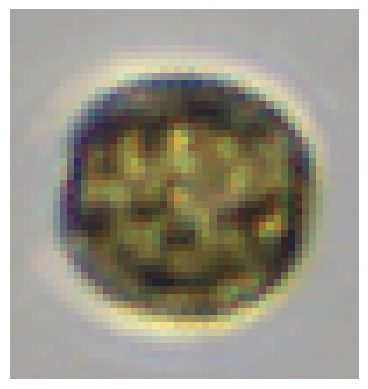

In [17]:
import cv2
import matplotlib.pyplot as plt
#path = "/content/drive/MyDrive/CV/CV_Project/filtered.csv/files/_SELECT_l_ID_as_library_id_l_name_pl_particle_pi2_image_pp_ch2_c_202404132221.csv-604.png"
image = cv2.imread(path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [18]:
top_5_filtered_df['image'] = top_5_filtered_df['image'].apply(convert_path)

In [19]:
top_5_filtered_df.iloc[0]['image']

'/kaggle/input/cv-data/filtered.csv-20240417T033754Z-001/filtered.csv/files/_SELECT_l_ID_as_library_id_l_name_pl_particle_pi2_image_pp_ch2_c_202404132221.csv-599.png'

In [20]:
import pandas as pd
# from google.colab.patches import cv2_imshow
import cv2

class_values = top_5_filtered_df['library_id'].unique()
print(class_values)
sampled_values = []

for class_value in class_values:
    class_rows = top_5_filtered_df[top_5_filtered_df['library_id'] == class_value]
    sampled_rows = class_rows.sample(n=10, random_state=42)
    images = sampled_rows['image'].tolist()
    metadata = sampled_rows

    sampled_values.append({"class_label":class_value,
                      "images":images,"metadata":metadata})

for sample in sampled_values:
  print(sample["class_label"])
#   for image_path in sample["images"]:
#     image = cv2.imread(image_path)
#     if image is not None:
#         cv2_imshow(image)
#     else:
#         print(f"Error reading image: {image_path}")


[  9  12  43  46  53 999]
9
12
43
46
53
999


In [21]:
# import pandas as pd
# import cv2
# import numpy as np

# class_values = top_5_filtered_df['library_id'].unique()
# sampled_images = []

# for class_value in class_values:
#     class_rows = top_5_filtered_df[top_5_filtered_df['library_id'] == class_value]
#     images = class_rows['image'].tolist()

#     for image_path in images:
#         image = cv2.imread(image_path)
#         if image is not None:
#             # Resize the image to the required input size of your image classification model
#             image = cv2.resize(image, (224, 224))  # Adjust dimensions as needed
#             # Convert the image to RGB (if it's in BGR format)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             # Normalize the image pixels to the range [0, 1]
#             image = image.astype(np.float32) / 255.0
#             # Add the preprocessed image to the list
#             sampled_images.append({"image": image, "class_label": class_value})
#         else:
#             print(f"Error reading image: {image_path}")

# Now you have all sampled images and their corresponding class labels prepared for classification
# You can pass them to your pre-trained image classification model


In [22]:
# #Without normalization
# import pandas as pd
# import cv2
# import numpy as np

# class_values = top_5_filtered_df['library_id'].unique()
# sampled_images_woNorm = []


# for class_value in class_values:
#     class_rows = top_5_filtered_df[top_5_filtered_df['library_id'] == class_value]
#     images = class_rows['image'].tolist()

#     for image_path in images:
#         image = cv2.imread(image_path)
#         if image is not None:
#             # Resize the image to the required input size of your image classification model
#             image = cv2.resize(image, (224, 224))  # Adjust dimensions as needed
#             # Convert the image to RGB (if it's in BGR format)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             # Add the preprocessed image to the list
#             sampled_images_woNorm.append({"image": image, "class_label": class_value})
#         else:
#             print(f"Error reading image: {image_path}")

# # Now you have all sampled images and their corresponding class labels prepared for classification
# # You can pass them to your pre-trained image classification model


In [23]:
# import pandas as pd
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder

# # Split the sampled_images_woNorm dataset into features (X) and labels (y)
# X = np.array([sampled_image["image"] for sampled_image in sampled_images_woNorm])
# y = np.array([sampled_image["class_label"] for sampled_image in sampled_images_woNorm])

# # Now you have X_train, X_test, y_train, and y_test ready for training and testing
# # You can pass them to your CNN model for training and evaluation
# # print(y)
# num_classes = len(np.unique(y))
# print(num_classes)
# num_classes=5

# # Fit OneHotEncoder to your class labels and transform them
# encoder = OneHotEncoder(sparse=False)
# y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# print(y_encoded.shape)
# print(X.shape)

# # Print the unique encoded class labels
# print("Encoded class labels:", np.unique(y))

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify = y_encoded)


In [24]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder



# # Create the encoder instance
# encoder = OneHotEncoder(sparse=False)

# # Reshape y to (-1, 1) because it is expected to be 2D and fit_transform
# y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# # Get feature names corresponding to each unique class
# feature_names = encoder.get_feature_names_out(input_features=['label'])

# # Print the mapping of original labels to one-hot encoded labels
# print("Original label -> One-hot encoded")
# for original, encoded in zip(y, y_encoded):
#     print(f"{original} -> {encoded}")

# # Optionally, display feature names
# print("\nFeature names for one-hot encoded columns:")
# print(feature_names)


# Delete the folder code(ignore it)

In [25]:
# base_directory = '/kaggle/working/'
# import os
# import shutil

# def remove_subfolders(directory):
#     # Check if the directory exists
#     if not os.path.exists(directory):
#         print("Directory does not exist:", directory)
#         return
    
#     # List all entries in the directory
#     for entry in os.listdir(directory):
#         # Create full path to the entry
#         entry_path = os.path.join(directory, entry)
#         # Check if the entry is a directory
#         if os.path.isdir(entry_path):
#             # Recursively delete the directory
#             shutil.rmtree(entry_path)
#             print(f"Removed: {entry_path}")



# # Call the function
# remove_subfolders(base_directory)


Removed: /kaggle/working/top-five
Removed: /kaggle/working/.virtual_documents


# Lets first seperate for each class them into train, test and validation

In [26]:
import os

In [27]:
newpath = r'/kaggle/working/top-five' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [28]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Base directory where all images are stored
# base_directory = '/kaggle/input/cv-data/filtered.csv-20240417T033754Z-001/filtered.csv/files'

# # New base directory where train, test, and validation folders will be created
# new_base_directory = '/kaggle/working/top-five'

# # Create train, test, validation directories
# for split in ['train', 'test', 'validation']:
#     os.makedirs(os.path.join(new_base_directory, split), exist_ok=True)

# # Read DataFrame - Assuming it's already loaded as top_5_filtered_df
# top_5_filtered_df['library_id'] = top_5_filtered_df['library_id'].astype(str)  # Ensure class labels are strings

# # Splitting the dataset into train, test, and validation sets
# train_df, test_df = train_test_split(top_5_filtered_df, test_size=0.2, stratify=top_5_filtered_df['library_id'], random_state=42)
# test_df, val_df = train_test_split(test_df, test_size=0.5, stratify=test_df['library_id'], random_state=42)

# # Function to copy images to the designated folders
# def copy_images(dataframe, split_type):
#     for index, row in dataframe.iterrows():
#         file_path = os.path.join(base_directory, row['image'])
#         class_folder = os.path.join(new_base_directory, split_type, row['library_id'])
#         os.makedirs(class_folder, exist_ok=True)  # Create class folder if it doesn't exist
#         shutil.copy(file_path, os.path.join(class_folder, os.path.basename(file_path)))

# # Copy files to respective directories
# copy_images(train_df, 'train')
# copy_images(test_df, 'test')
# copy_images(val_df, 'validation')

# print("Files have been copied into train, test, and validation folders.")


In [29]:
import os
import shutil
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Base directory where all images are stored
base_directory = '/kaggle/input/cv-data/filtered.csv-20240417T033754Z-001/filtered.csv/files'

# New base directory where train, test, and validation folders will be created
new_base_directory = '/kaggle/working/top-five'

# Create train, test, validation directories
for split in ['train', 'test', 'validation']:
    os.makedirs(os.path.join(new_base_directory, split), exist_ok=True)

# Read DataFrame - Assuming it's already loaded as top_5_filtered_df
top_5_filtered_df['library_id'] = top_5_filtered_df['library_id'].astype(str)  # Ensure class labels are strings

# Splitting the dataset into train, test, and validation sets
train_df, test_df = train_test_split(top_5_filtered_df, test_size=0.2, stratify=top_5_filtered_df['library_id'], random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.5, stratify=test_df['library_id'], random_state=42)

def apply_sobel_edge_detection(image_path):
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Calculate the x and y gradients using the Sobel operator
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    # Calculate the magnitude of the gradients
    sobel = np.sqrt(sobelx**2 + sobely**2)
    # Convert to uint8
    sobel = np.uint8(255 * sobel / np.max(sobel))
    return sobel

# Function to copy images to the designated folders
def copy_and_process_images(dataframe, split_type):
    for index, row in dataframe.iterrows():
        file_path = os.path.join(base_directory, row['image'])
        processed_image = apply_sobel_edge_detection(file_path)
        class_folder = os.path.join(new_base_directory, split_type, row['library_id'])
        os.makedirs(class_folder, exist_ok=True)  # Create class folder if it doesn't exist
        output_path = os.path.join(class_folder, os.path.basename(file_path))
        cv2.imwrite(output_path, processed_image)  # Save the processed image

# Copy and process files to respective directories
copy_and_process_images(train_df, 'train')
copy_and_process_images(test_df, 'test')
copy_and_process_images(val_df, 'validation')

print("Files have been copied and processed into train, test, and validation folders.")


Files have been copied and processed into train, test, and validation folders.


In [30]:
base_directory = '/kaggle/working/top-five/train' # Make sure to set this to your actual base directory

counts_dic_train = {}
for subfolder in os.listdir(base_directory):
    current_dir = os.path.join(base_directory, subfolder)  # Corrected from 'base_folder' to 'base_directory'
    count = 0
    for _ in os.listdir(current_dir):
        count += 1
    counts_dic_train[subfolder] = count  # Use the subfolder name as the dictionary key

print(counts_dic_train)

{'53': 186, '46': 202, '43': 142, '12': 123, '999': 1655, '9': 139}


In [31]:
base_directory = '/kaggle/working/top-five/test' # Make sure to set this to your actual base directory

counts_dic_test = {}
for subfolder in os.listdir(base_directory):
    current_dir = os.path.join(base_directory, subfolder)  # Corrected from 'base_folder' to 'base_directory'
    count = 0
    for _ in os.listdir(current_dir):
        count += 1
    counts_dic_test[subfolder] = count  # Use the subfolder name as the dictionary key

print(counts_dic_test)

{'53': 24, '46': 25, '43': 18, '12': 15, '999': 207, '9': 17}


In [32]:
base_directory = '/kaggle/working/top-five/validation' # Make sure to set this to your actual base directory

counts_dic_validation = {}
for subfolder in os.listdir(base_directory):
    current_dir = os.path.join(base_directory, subfolder)  # Corrected from 'base_folder' to 'base_directory'
    count = 0
    for _ in os.listdir(current_dir):
        count += 1
    counts_dic_validation[subfolder] = count  # Use the subfolder name as the dictionary key

print(counts_dic_validation)

{'53': 23, '46': 26, '43': 17, '12': 16, '999': 207, '9': 17}


# We will remove the excess images of '999' class

How many to remove?
We will take the second largest number of images, from the folder and then keep those many images for the 999 class

### Removing images from test

In [34]:
import os
import random
import shutil

def limit_images_in_directory(directory, max_images):
    
    # List all files in the directory
    files = [file for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(files) <= max_images:
        print("No need to delete any images, the current number is within the limit.")
        return

    # Calculate how many files need to be deleted
    files_to_delete = len(files) - max_images

    # Randomly select files to delete
    files_to_delete = random.sample(files, files_to_delete)

    # Delete the selected files
    for file in files_to_delete:
        file_path = os.path.join(directory, file)
        os.remove(file_path)
        print(f"Deleted {file}")

#     print(f"{len(files_to_delete)} images have been deleted to limit the directory to {max_images} images.")

# Example usage
directory_path = '/kaggle/working/top-five/test/999'  # Update this path to your directory
max_images = 30  # Set the maximum number of images you want to keep

limit_images_in_directory(directory_path, max_images)


No need to delete any images, the current number is within the limit.


### Similarly for the validation

In [ ]:
import os
import random
import shutil

def limit_images_in_directory(directory, max_images):
    
    # List all files in the directory
    files = [file for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(files) <= max_images:
        print("No need to delete any images, the current number is within the limit.")
        return

    # Calculate how many files need to be deleted
    files_to_delete = len(files) - max_images

    # Randomly select files to delete
    files_to_delete = random.sample(files, files_to_delete)

    # Delete the selected files
    for file in files_to_delete:
        file_path = os.path.join(directory, file)
        os.remove(file_path)
        print(f"Deleted {file}")

#     print(f"{len(files_to_delete)} images have been deleted to limit the directory to {max_images} images.")

# Example usage
directory_path = '/kaggle/working/top-five/validation/999'  # Update this path to your directory
max_images = 30  # Set the maximum number of images you want to keep

limit_images_in_directory(directory_path, max_images)


### Similarly removing images from the trainig

In [ ]:
import os
import random
import shutil

def limit_images_in_directory(directory, max_images):
    
    # List all files in the directory
    files = [file for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(files) <= max_images:
        print("No need to delete any images, the current number is within the limit.")
        return

    # Calculate how many files need to be deleted
    files_to_delete = len(files) - max_images

    # Randomly select files to delete
    files_to_delete = random.sample(files, files_to_delete)

    # Delete the selected files
    for file in files_to_delete:
        file_path = os.path.join(directory, file)
        os.remove(file_path)
        print(f"Deleted {file}")

#     print(f"{len(files_to_delete)} images have been deleted to limit the directory to {max_images} images.")

# Example usage
directory_path = '/kaggle/working/top-five/train/999'  # Update this path to your directory
max_images = 500  # Set the maximum number of images you want to keep

limit_images_in_directory(directory_path, max_images)


In [37]:
print(f"Number of images after deletion in 999 folder in train is: {len(os.listdir('/kaggle/working/top-five/train/999'))}")
print(f"Number of images after deletion in 999 folder in validation is: {len(os.listdir('/kaggle/working/top-five//validation/999'))}")
print(f"Number of images after deletion in 999 folder in Testing is: {len(os.listdir('/kaggle/working/top-five/test/999'))}")

Number of images after deletion in 999 folder in train is: 500
Number of images after deletion in 999 folder in validation is: 30
Number of images after deletion in 999 folder in Testing is: 30


# Lets seperate the dataset based on classes


This below code is directly create an subfolder for each class without dividing first train, test, split

In [ ]:
# import os
# import shutil
# import pandas as pd

# # Assuming 'top_5_filtered_df' contains 'image' and 'library_id' where 'image' is the path to the images.
# # Update the base_directory to a writable directory
# base_directory = '/kaggle/working/top-five'

# # Create the base directory if it doesn't exist
# if not os.path.exists(base_directory):
#     os.makedirs(base_directory)

# # Loop through the dataframe
# for index, row in top_5_filtered_df.iterrows():
#     image_path = row['image']
#     class_name = row['library_id']

#     # Create a directory for the class if it doesn't exist
#     class_directory = os.path.join(base_directory, class_name)
#     if not os.path.exists(class_directory):
#         os.makedirs(class_directory)

#     # Define the new path for the image (assuming image_path contains full path)
#     new_image_path = os.path.join(class_directory, os.path.basename(image_path))

#     # Check if original path is accessible
#     original_image_path = os.path.join('/kaggle/input/cv-data/filtered.csv-20240417T033754Z-001/filtered.csv/files', image_path)  # Update with correct path
#     if os.path.exists(original_image_path):
#         # Move the image to the new directory
#         shutil.copy(original_image_path, new_image_path)  # Using copy instead of move to avoid permission issues

# print("Images have been organized into class-based directories.")


# Updated code to add certain number of images only to train folder

In [ ]:
# !pip uninstall -y tensorflow
# !pip install tensorflow==2.15.0

In [38]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# Directory containing training data organized by class
base_directory = '/kaggle/working/top-five/train'

# Minimum number of images desired per class
min_images_per_class = 300  # Update this number based on your requirement

# Loop through each class directory in the train directory
for class_folder in os.listdir(base_directory):
    class_dir_path = os.path.join(base_directory, class_folder)
    if not os.path.isdir(class_dir_path):
        continue  # Skip if not a directory

    # Count how many images currently exist
    current_image_count = len([name for name in os.listdir(class_dir_path) if name.lower().endswith(('.png', '.jpg', '.jpeg'))])
    images_needed = min_images_per_class - current_image_count

    # If additional images are needed, perform augmentation
    if images_needed > 0:
        all_images = [os.path.join(class_dir_path, img) for img in os.listdir(class_dir_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Loop to generate the required number of images
        while images_needed > 0:
            for image_path in all_images:
                if images_needed <= 0:
                    break

                img = load_img(image_path)  # Load image
                img_array = img_to_array(img)  # Convert image to array
                img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for generator

                # Randomly select an augmentation method
                augmentation_methods = [
                    {'rotation_range': random.randint(0, 30)},
                    {'width_shift_range': random.uniform(0.1, 0.3)},
                    {'height_shift_range': random.uniform(0.1, 0.3)},
                    {'horizontal_flip': True},
                    {'vertical_flip': True},
                    {'shear_range': random.uniform(0.2, 0.3)}
                    
                ]
                augmentation_choice = random.choice(augmentation_methods)
                datagen = ImageDataGenerator(**augmentation_choice, fill_mode='nearest')

                # Generate one new image and save
                for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_dir_path, save_prefix='aug_', save_format='jpeg'):
                    images_needed -= 1
                    break  # Break after generating one image to move to the next image

print("Image augmentation complete. Each class now has at least {} images.".format(min_images_per_class))


Image augmentation complete. Each class now has at least 300 images.


In [57]:
base_directory = '/kaggle/working/top-five/validation' # Make sure to set this to your actual base directory

counts_dic_train = {}
for subfolder in os.listdir(base_directory):
    current_dir = os.path.join(base_directory, subfolder)  # Corrected from 'base_folder' to 'base_directory'
    count = 0
    for _ in os.listdir(current_dir):
        count += 1
    counts_dic_train[subfolder] = count  # Use the subfolder name as the dictionary key

print(counts_dic_train)

{'53': 30, '46': 30, '43': 30, '12': 30, '999': 30, '9': 30}


# Lets add 30 more images atleast to validation and testing

In [40]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# Directory containing training data organized by class
base_directory = '/kaggle/working/top-five/test'

# Minimum number of images desired per class
min_images_per_class = 30 

# Loop through each class directory in the train directory
for class_folder in os.listdir(base_directory):
    class_dir_path = os.path.join(base_directory, class_folder)
    if not os.path.isdir(class_dir_path):
        continue  # Skip if not a directory


    # Count how many images currently exist
    current_image_count = len([name for name in os.listdir(class_dir_path) if name.lower().endswith(('.png', '.jpg', '.jpeg'))])
    images_needed = min_images_per_class - current_image_count

    # If additional images are needed, perform augmentation
    if images_needed > 0:
        all_images = [os.path.join(class_dir_path, img) for img in os.listdir(class_dir_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Loop to generate the required number of images
        while images_needed > 0:
            for image_path in all_images:
                if images_needed <= 0:
                    break

                img = load_img(image_path)  # Load image
                img_array = img_to_array(img)  # Convert image to array
                img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for generator

                # Randomly select an augmentation method
                augmentation_methods = [
                    {'rotation_range': random.randint(0, 30)},
                    {'width_shift_range': random.uniform(0.1, 0.3)},
                    {'height_shift_range': random.uniform(0.1, 0.3)},
                    {'horizontal_flip': True},
                    {'vertical_flip': True},
                    {'shear_range': random.uniform(0.2, 0.3)}
                    
                ]
                augmentation_choice = random.choice(augmentation_methods)
                datagen = ImageDataGenerator(**augmentation_choice, fill_mode='nearest')

                # Generate one new image and save
                for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_dir_path, save_prefix='aug_', save_format='jpeg'):
                    images_needed -= 1
                    break  # Break after generating one image to move to the next image

print("Image augmentation complete. Each class now has at least {} images.".format(min_images_per_class))


Image augmentation complete. Each class now has at least 30 images.


In [41]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# Directory containing training data organized by class
base_directory = '/kaggle/working/top-five/validation'

# Minimum number of images desired per class
min_images_per_class = 30  # Update this number based on your requirement

# Loop through each class directory in the train directory
for class_folder in os.listdir(base_directory):
    class_dir_path = os.path.join(base_directory, class_folder)
    if not os.path.isdir(class_dir_path):
        continue  # Skip if not a directory

    # Count how many images currently exist
    current_image_count = len([name for name in os.listdir(class_dir_path) if name.lower().endswith(('.png', '.jpg', '.jpeg'))])
    images_needed = min_images_per_class - current_image_count

    # If additional images are needed, perform augmentation
    if images_needed > 0:
        all_images = [os.path.join(class_dir_path, img) for img in os.listdir(class_dir_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Loop to generate the required number of images
        while images_needed > 0:
            for image_path in all_images:
                if images_needed <= 0:
                    break

                img = load_img(image_path)  # Load image
                img_array = img_to_array(img)  # Convert image to array
                img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for generator

                # Randomly select an augmentation method
                augmentation_methods = [
                    {'rotation_range': random.randint(0, 30)},
                    {'width_shift_range': random.uniform(0.1, 0.3)},
                    {'height_shift_range': random.uniform(0.1, 0.3)},
                    {'horizontal_flip': True},
                    {'vertical_flip': True},
                    {'shear_range': random.uniform(0.2, 0.3)}
                    
                ]
                augmentation_choice = random.choice(augmentation_methods)
                datagen = ImageDataGenerator(**augmentation_choice, fill_mode='nearest')

                # Generate one new image and save
                for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_dir_path, save_prefix='aug_', save_format='jpeg'):
                    images_needed -= 1
                    break  # Break after generating one image to move to the next image

print("Image augmentation complete. Each class now has at least {} images.".format(min_images_per_class))


Image augmentation complete. Each class now has at least 30 images.


Now we have added total of 300 images to each class.

# Lets build the models

# Simple model

In [42]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [119]:
# Directories
train_dir = '/kaggle/working/top-five/train'
validation_dir = '/kaggle/working/top-five/validation'
test_dir = '/kaggle/working/top-five/test'

# Image dimensions and batch size
img_width, img_height = 224, 224  # Change depending on your requirements
batch_size = 128

# Data generators for loading images
train_datagen = ImageDataGenerator(
    rescale=1./255
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 2000 images belonging to 6 classes.
Found 180 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


In [59]:
# Model parameters
l2_lambda = 0.001  # Regularization factor
initial_learning_rate = 0.001
decay_steps = 1000  # Steps after which to decay the learning rate
decay_rate = 0.9  # Rate of decay

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# Optimizer with decay
optimizer = Adam(learning_rate=lr_schedule)

# Model architecture with L2 regularization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3), kernel_regularizer=l2(l2_lambda)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_lambda)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(l2_lambda)),
    Dense(train_generator.num_classes, activation='softmax')
])

print(f"Number of classes are {train_generator.num_classes}")

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history_simple_cnn = model.fit(
    train_generator,
    epochs=30,  # Number of epochs to train for
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Ensuring all training data is used
    validation_steps=validation_generator.samples // batch_size,  # Ensuring all validation data is used
    callbacks=[early_stopping]  # Include the early stopping callback
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

# Storing the last training loss and accuracy
train_loss = history_simple_cnn.history['loss'][-1]
train_accuracy = history_simple_cnn.history['accuracy'][-1]

# Print the results
print("Training Loss: {:.4f}, Training Accuracy: {:.2f}%".format(train_loss, train_accuracy * 100))
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy * 100))

Number of classes are 6
Epoch 1/30
15/15 [==============================] - 6s 308ms/step - loss: 4.6027 - accuracy: 0.3275 - val_loss: 2.1868 - val_accuracy: 0.5234
Epoch 2/30
15/15 [==============================] - 5s 310ms/step - loss: 1.7530 - accuracy: 0.6378 - val_loss: 1.3974 - val_accuracy: 0.7109
Epoch 3/30
15/15 [==============================] - 4s 282ms/step - loss: 1.1801 - accuracy: 0.7991 - val_loss: 1.1700 - val_accuracy: 0.7344
Epoch 4/30
15/15 [==============================] - 4s 288ms/step - loss: 0.9170 - accuracy: 0.8542 - val_loss: 1.1162 - val_accuracy: 0.7344
Epoch 5/30
15/15 [==============================] - 4s 268ms/step - loss: 0.7101 - accuracy: 0.9241 - val_loss: 1.1297 - val_accuracy: 0.7422
Epoch 6/30
15/15 [==============================] - 4s 267ms/step - loss: 0.5623 - accuracy: 0.9630 - val_loss: 1.2239 - val_accuracy: 0.6953
Epoch 7/30
15/15 [==============================] - 4s 288ms/step - loss: 0.4838 - accuracy: 0.9679 - val_loss: 0.8430 - val

In [60]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy from a Keras training history object.
    
    Parameters:
    - history: A Keras History object returned from the fit method.
    """
    # Access the history dictionary
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    # Plotting Training and Validation Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    

 

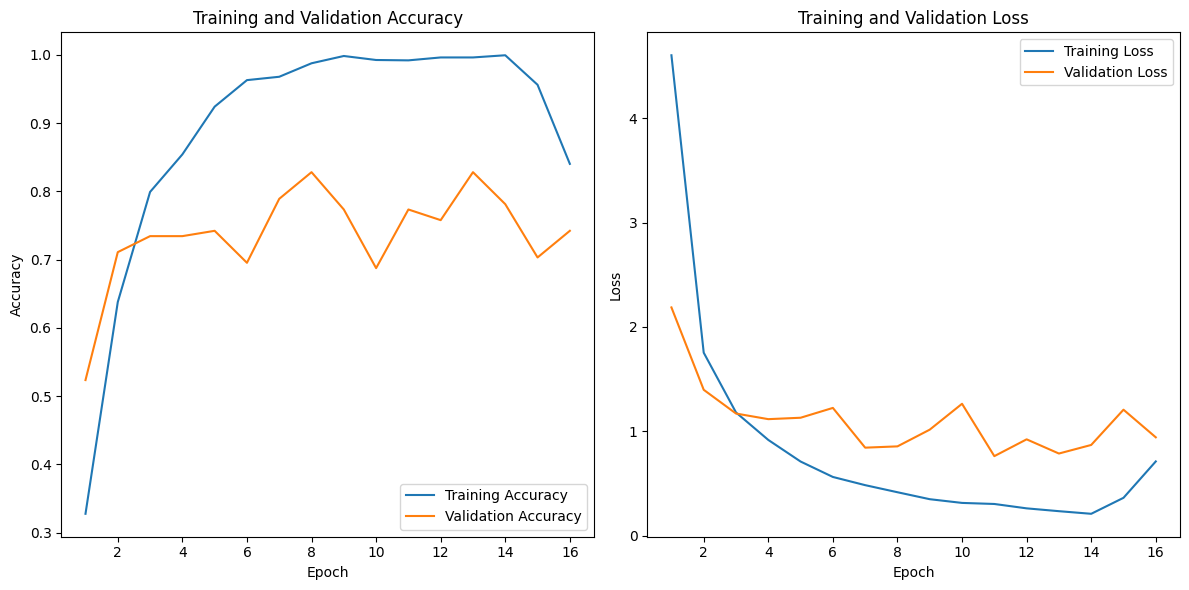

In [61]:
plot_training_history(history_simple_cnn)

remove this old function

In [106]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, classification_report
# from tensorflow.keras.models import Model

# def generate_classification_report(model, data_generator):
#    # Example dictionary of class labels
#     label_dict = {
#     46:"Peridinium", 
#     53:"Straustrum", 
#     43:"Ceratrium", 
#     9:"Cyclotella", 
#     12:"Microcystis", 
#     25:"Pedastrium", 
#     2:"Anabaena-coiled", 
#     44:"Fragillaria", 
#     1:"Anabaena", 
#     27: 'Planktothrix', 
#     999: 'other' 
#     }

#     # Ensure the generator is not shuffling data
#     data_generator.shuffle = False
#     data_generator.reset()
    
#     # Initialize lists to store true labels and predictions
#     y_true = []
#     y_pred = []

#     # Collect predictions and labels
#     for _ in range(len(data_generator)):
#         X_batch, y_batch = next(data_generator)
#         y_batch_pred = model.predict(X_batch)
#         y_batch_pred = np.argmax(y_batch_pred, axis=1)
#         y_batch_true = np.argmax(y_batch, axis=1)
#         y_true.extend(y_batch_true)
#         y_pred.extend(y_batch_pred)

#     # Calculate the confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
    
#     keys = [values for values in data_generator.class_indices.keys()]
#     print(keys)
#     cm_df = pd.DataFrame(cm, index=data_generator.class_indices.keys(), columns=data_generator.class_indices.keys())
#     print(cm_df)
#     # Plot the confusion matrix
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()
    
#     # Calculate correct and misclassifications per class
#     print("\nClass-wise Correct and Misclassified Counts:")
#     for i, (index, row) in enumerate(cm_df.iterrows()):
#         correct = row[index]
#         misclassified = np.sum(row) - correct
#         print(f"{index}: Correct = {correct}, Misclassified = {misclassified}")
    
#     # Print classification report
#     print("\nClassification Report:")
#     report = classification_report(y_true, y_pred, target_names=data_generator.class_indices.keys(), zero_division=0)
#     print(report)


In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model

def generate_classification_report(model, data_generator):
    label_dict = {
    46:"Peridinium", 
    53:"Straustrum", 
    43:"Ceratrium", 
    9:"Cyclotella", 
    12:"Microcystis", 
    25:"Pedastrium", 
    2:"Anabaena-coiled", 
    44:"Fragillaria", 
    1:"Anabaena", 
    27: 'Planktothrix', 
    999: 'other' 
    }

    # Ensure the generator is not shuffling data
    data_generator.shuffle = False
    data_generator.reset()
    
    # Initialize lists to store true labels and predictions
    y_true = []
    y_pred = []

    # Collect predictions and labels
    for _ in range(len(data_generator)):
        X_batch, y_batch = next(data_generator)
        y_batch_pred = model.predict(X_batch)
        y_batch_pred = np.argmax(y_batch_pred, axis=1)
        y_batch_true = np.argmax(y_batch, axis=1)
        y_true.extend(y_batch_true)
        y_pred.extend(y_batch_pred)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    keys = [label_dict.get(int(values), "unknown") for values in data_generator.class_indices.keys()]
#     print(keys)
#     print([values for values in data_generator.class_indices.keys()])
    cm_df = pd.DataFrame(cm, index=keys, columns=keys)
#     print(cm_df)
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # Calculate correct and misclassifications per class
    print("\nClass-wise Correct and Misclassified Counts:")
    for i, (index, row) in enumerate(cm_df.iterrows()):
        correct = row[index]
        misclassified = np.sum(row) - correct
        print(f"{index}: Correct = {correct}, Misclassified = {misclassified}")
    
    # Print classification report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=data_generator.class_indices.keys(), zero_division=0)
    print(report)




2/2 [==============================] - 0s 15ms/step


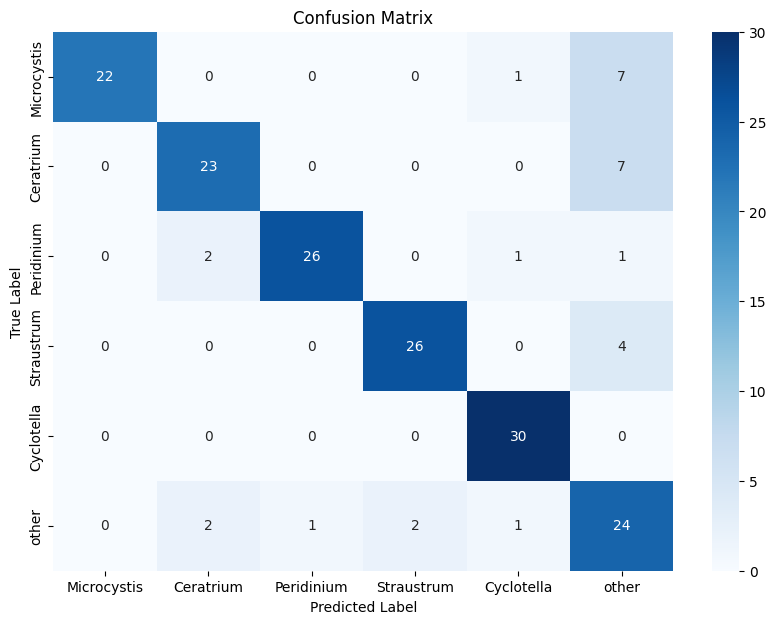


Class-wise Correct and Misclassified Counts:
Microcystis: Correct = 22, Misclassified = 8
Ceratrium: Correct = 23, Misclassified = 7
Peridinium: Correct = 26, Misclassified = 4
Straustrum: Correct = 26, Misclassified = 4
Cyclotella: Correct = 30, Misclassified = 0
other: Correct = 24, Misclassified = 6

Classification Report:
              precision    recall  f1-score   support

          12       1.00      0.73      0.85        30
          43       0.85      0.77      0.81        30
          46       0.96      0.87      0.91        30
          53       0.93      0.87      0.90        30
           9       0.91      1.00      0.95        30
         999       0.56      0.80      0.66        30

    accuracy                           0.84       180
   macro avg       0.87      0.84      0.85       180
weighted avg       0.87      0.84      0.85       180



In [121]:
generate_classification_report(model, test_generator)

Seems to be performing really well for an really simple CNN, now lets try the other biggies

## Alenet

Since alexnet uses the input shape to be 227, we need to reconfig the input shape to be 227 instead of 224

In [122]:
# Image dimensions and batch size
img_width, img_height = 227, 227  
batch_size = 128

# Data generators for loading images
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 2000 images belonging to 6 classes.
Found 180 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


In [115]:
model_alexnet = Sequential([
    Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(227, 227, 3)),
    MaxPooling2D(3, strides=2),
    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(3, strides=2),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(3, strides=2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])



lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9, staircase=True)
optimizer = Adam(learning_rate=lr_schedule)

model_alexnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit model
history_alexnet = model_alexnet.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


test_loss, test_accuracy = model_alexnet.evaluate(test_generator)

# Storing the last training loss and accuracy
train_loss = history_alexnet.history['loss'][-1]
train_accuracy = history_alexnet.history['accuracy'][-1]

# Print the results
print("Training Loss: {:.4f}, Training Accuracy: {:.2f}%".format(train_loss, train_accuracy * 100))
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy * 100))

Epoch 1/30
16/16 [==============================] - 21s 652ms/step - loss: 2.4741 - accuracy: 0.2270 - val_loss: 1.7099 - val_accuracy: 0.2556
Epoch 2/30
16/16 [==============================] - 5s 292ms/step - loss: 1.5129 - accuracy: 0.3590 - val_loss: 1.2791 - val_accuracy: 0.4167
Epoch 3/30
16/16 [==============================] - 5s 293ms/step - loss: 1.1434 - accuracy: 0.5215 - val_loss: 0.9877 - val_accuracy: 0.5722
Epoch 4/30
16/16 [==============================] - 5s 294ms/step - loss: 0.9449 - accuracy: 0.6000 - val_loss: 0.7513 - val_accuracy: 0.7056
Epoch 5/30
16/16 [==============================] - 5s 286ms/step - loss: 0.7626 - accuracy: 0.7085 - val_loss: 0.6617 - val_accuracy: 0.7389
Epoch 6/30
16/16 [==============================] - 5s 293ms/step - loss: 0.5740 - accuracy: 0.7725 - val_loss: 0.5000 - val_accuracy: 0.8000
Epoch 7/30
16/16 [==============================] - 5s 283ms/step - loss: 0.4721 - accuracy: 0.8120 - val_loss: 0.4541 - val_accuracy: 0.8667
Epoch

There is an minor improvement, let see how the graph looks like

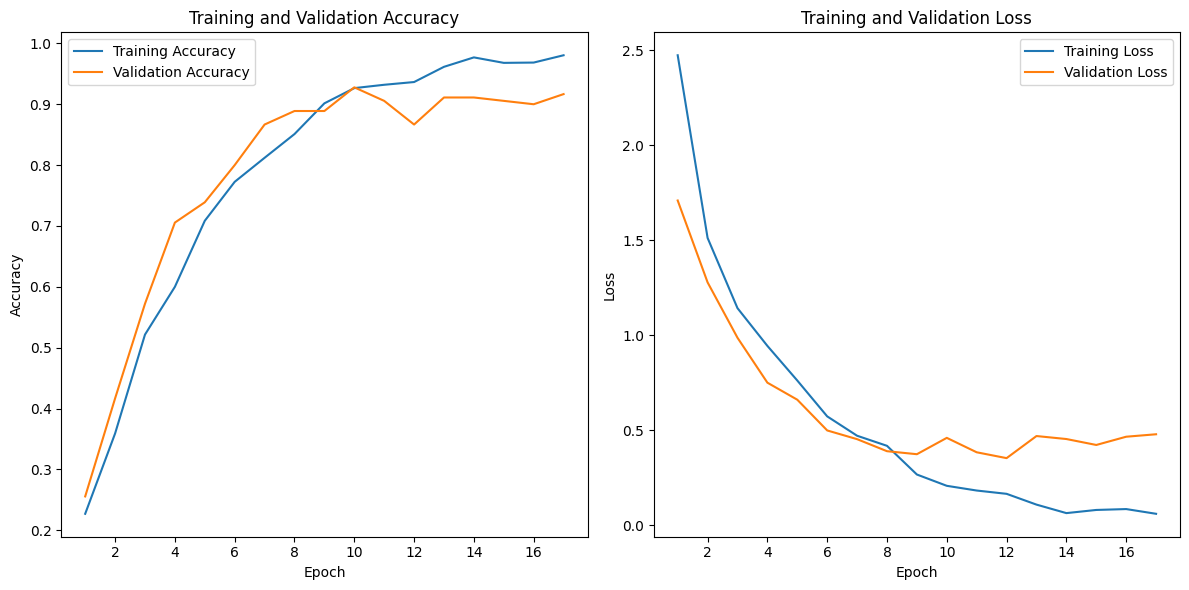

In [116]:
plot_training_history(history_alexnet)

Really good performance from alexnet, now lets try other models.

2/2 [==============================] - 0s 19ms/step


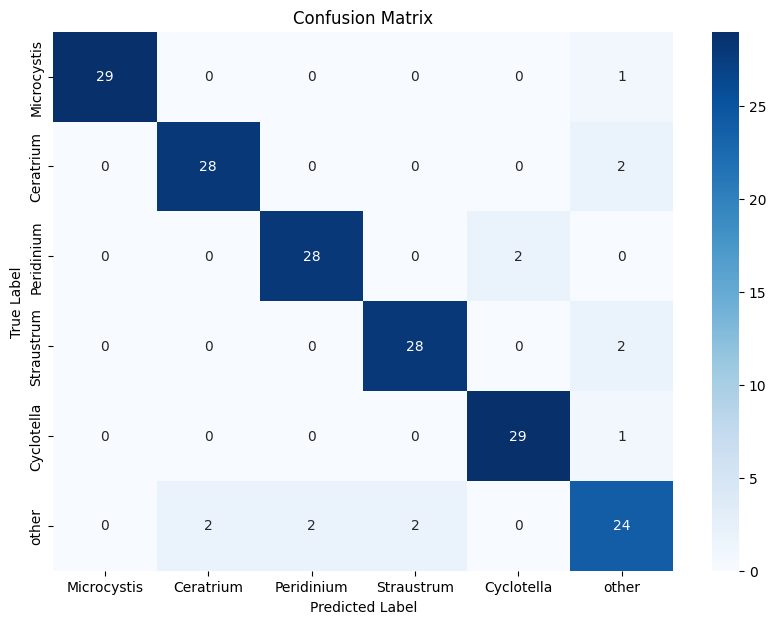


Class-wise Correct and Misclassified Counts:
Microcystis: Correct = 29, Misclassified = 1
Ceratrium: Correct = 28, Misclassified = 2
Peridinium: Correct = 28, Misclassified = 2
Straustrum: Correct = 28, Misclassified = 2
Cyclotella: Correct = 29, Misclassified = 1
other: Correct = 24, Misclassified = 6

Classification Report:
              precision    recall  f1-score   support

          12       1.00      0.97      0.98        30
          43       0.93      0.93      0.93        30
          46       0.93      0.93      0.93        30
          53       0.93      0.93      0.93        30
           9       0.94      0.97      0.95        30
         999       0.80      0.80      0.80        30

    accuracy                           0.92       180
   macro avg       0.92      0.92      0.92       180
weighted avg       0.92      0.92      0.92       180



In [123]:
generate_classification_report(model_alexnet, test_generator)

# Resnet

In [124]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
train_dir = '/kaggle/working/top-five/train'
validation_dir = '/kaggle/working/top-five/validation'
test_dir = '/kaggle/working/top-five/test'

# Image dimensions and batch size
img_width, img_height = 224, 224  # Change depending on your requirements
batch_size = 32

# Data generators for loading images
train_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2000 images belonging to 6 classes.
Found 180 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


In [125]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load ResNet50 base model without pretrained weights
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Adding custom Layers 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  
x = Dropout(0.5)(x)  # Adding Dropout
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
print(train_generator.num_classes)
# Creating the final model 
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Make all layers trainable since we are training from scratch
for layer in resnet_model.layers:
    layer.trainable = True

# Compile the model with an appropriate optimizer and learning rate
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
resnet_history = resnet_model.fit(
    train_generator,
    epochs=50,  # Number of epochs may need to be increased since training from scratch
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = resnet_model.evaluate(test_generator)

# Print results
print("Training Loss: {:.4f}, Training Accuracy: {:.2f}%".format(resnet_history.history['loss'][-1], resnet_history.history['accuracy'][-1] * 100))
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy*100))


6
Epoch 1/50
63/63 [==============================] - 66s 451ms/step - loss: 10.5401 - accuracy: 0.3730 - val_loss: 4042.8315 - val_accuracy: 0.1667
Epoch 2/50
63/63 [==============================] - 22s 342ms/step - loss: 5.1389 - accuracy: 0.5040 - val_loss: 8.8575 - val_accuracy: 0.1444
Epoch 3/50
63/63 [==============================] - 22s 345ms/step - loss: 3.2542 - accuracy: 0.5775 - val_loss: 7.5656 - val_accuracy: 0.1889
Epoch 4/50
63/63 [==============================] - 22s 347ms/step - loss: 2.0996 - accuracy: 0.6580 - val_loss: 4.1353 - val_accuracy: 0.2722
Epoch 5/50
63/63 [==============================] - 22s 349ms/step - loss: 1.4234 - accuracy: 0.7455 - val_loss: 2.6709 - val_accuracy: 0.4722
Epoch 6/50
63/63 [==============================] - 22s 351ms/step - loss: 1.0722 - accuracy: 0.7750 - val_loss: 2.2736 - val_accuracy: 0.5222
Epoch 7/50
63/63 [==============================] - 22s 352ms/step - loss: 0.8977 - accuracy: 0.7805 - val_loss: 1.8400 - val_accuracy: 

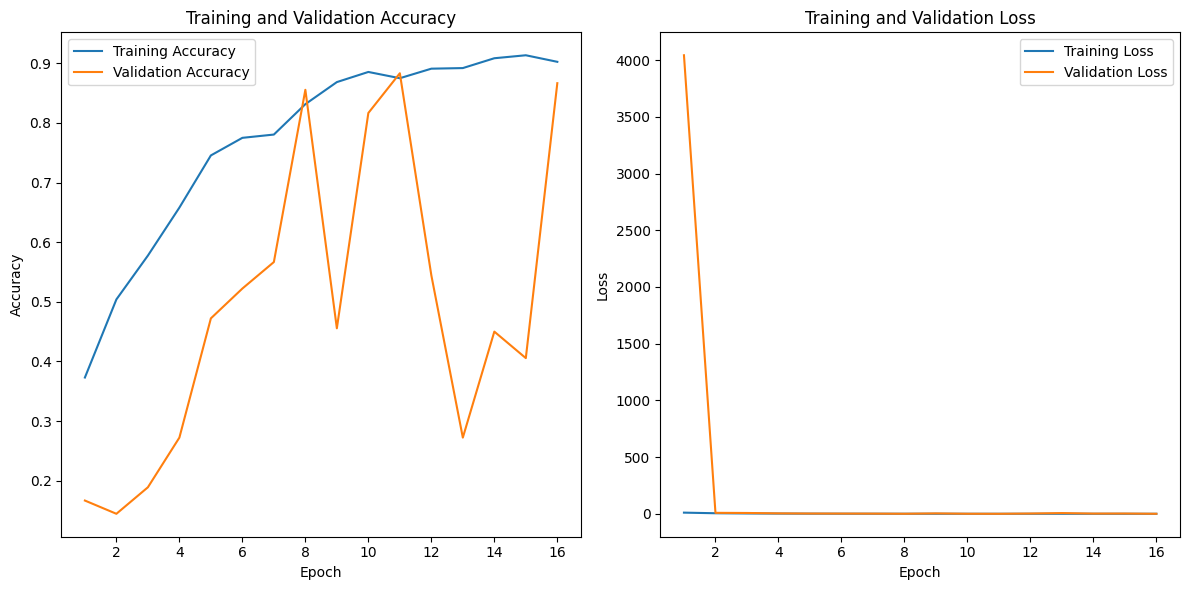

In [126]:
plot_training_history(resnet_history)

Since I am not using any pretrained weights, it will take longer to converge may be as an experiment, we need to run it for more time in the future like 200 epochs to see whether it goes, along with other hyper paraeters such weight decay, learning rate scheduler.

1/1 [==============================] - 1s 983ms/step


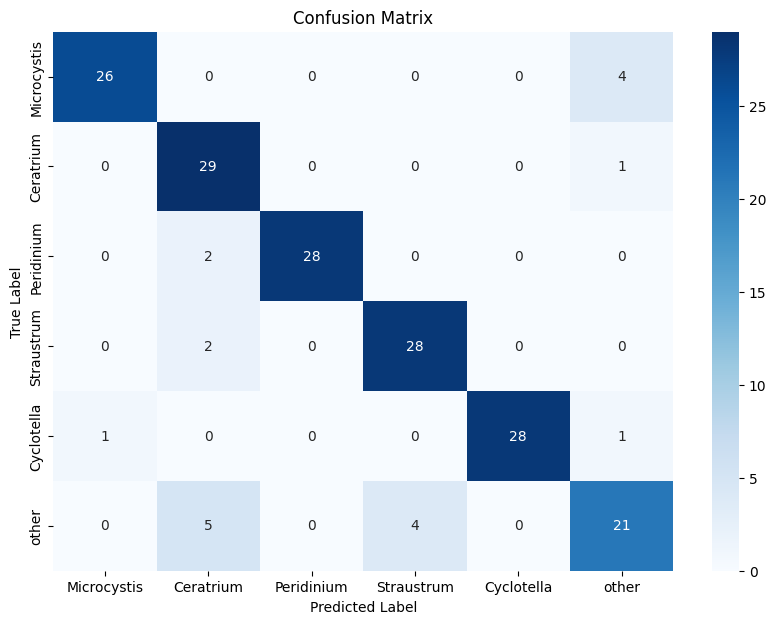


Class-wise Correct and Misclassified Counts:
Microcystis: Correct = 26, Misclassified = 4
Ceratrium: Correct = 29, Misclassified = 1
Peridinium: Correct = 28, Misclassified = 2
Straustrum: Correct = 28, Misclassified = 2
Cyclotella: Correct = 28, Misclassified = 2
other: Correct = 21, Misclassified = 9

Classification Report:
              precision    recall  f1-score   support

          12       0.96      0.87      0.91        30
          43       0.76      0.97      0.85        30
          46       1.00      0.93      0.97        30
          53       0.88      0.93      0.90        30
           9       1.00      0.93      0.97        30
         999       0.78      0.70      0.74        30

    accuracy                           0.89       180
   macro avg       0.90      0.89      0.89       180
weighted avg       0.90      0.89      0.89       180



In [127]:
# Usage example, assuming 'test_generator' is your test data generator and 'model' is your trained model
generate_classification_report(resnet_model, test_generator)

# 11 class classification

In [128]:
top_10_filtered_df = df[df['library_id'].isin([46,53,43,9,12,25,2,44,1,27])]
not_in_top_10_df = df[~df['library_id'].isin([46,53,43,9,12,25,2,44,1,27])]

not_in_top_10_df['library_id']=999
not_in_top_10_df['name'] = "Others"

top_10_filtered_df = pd.concat([top_10_filtered_df, not_in_top_10_df])

top_10_filtered_df.reset_index(drop=True, inplace=True)

top_10_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   library_id           3060 non-null   int64  
 1   name                 3060 non-null   object 
 2   particle             3059 non-null   float64
 3   image                3059 non-null   object 
 4   ch2_ch1Ratio         3030 non-null   float64
 5   edgeGradient         3059 non-null   float64
 6   ratioBlueGreen       3059 non-null   float64
 7   ratioRedBlue         3059 non-null   float64
 8   ratioRedGreen        3059 non-null   float64
 9   fiberCurl            3059 non-null   float64
 10  fiberStraightness    3059 non-null   float64
 11  geodesicAspectRatio  3059 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 287.0+ KB


/tmp/ipykernel_134/2726264907.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_in_top_10_df['library_id']=999
/tmp/ipykernel_134/2726264907.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_in_top_10_df['name'] = "Others"


In [129]:
top_10_filtered_df.head()

,library_id,name,particle,image,ch2_ch1Ratio,edgeGradient,ratioBlueGreen,ratioRedBlue,ratioRedGreen,fiberCurl,fiberStraightness,geodesicAspectRatio
0,1,10X_FOV 100 Anabaena WILL CRASH,47676.0,C:\sqlite\images\filtered.csv\files\_SELECT_l_...,NaN,118.626556,0.940923,1.072899,1.009515,0.262735,0.791932,0.118967
1,1,10X_FOV 100 Anabaena WILL CRASH,1713447.0,C:\sqlite\images\filtered.csv\files\_SELECT_l_...,0.0,97.245370,1.002229,0.995190,0.997409,0.610796,0.620811,0.073763
2,1,10X_FOV 100 Anabaena WILL CRASH,2643419.0,C:\sqlite\images\filtered.csv\files\_SELECT_l_...,0.0,77.308824,1.001570,0.997306,0.998871,0.433340,0.697671,0.098531
3,1,10X_FOV 100 Anabaena WILL CRASH,2715141.0,C:\sqlite\images\filtered.csv\files\_SELECT_l_...,0.0,74.448276,1.000309,1.000353,1.000661,0.003502,0.996510,0.417987
4,1,10X_FOV 100 Anabaena WILL CRASH,2734501.0,C:\sqlite\images\filtered.csv\files\_SELECT_l_...,0.0,107.162437,1.005026,0.989868,0.994843,0.117837,0.894585,0.162788


In [130]:
# If 'library_id' is a string type
top_10_filtered_df[top_10_filtered_df['library_id'] == '43'].head()

# If 'library_id' is indeed an integer type, your original code would be correct:
# top_10_filtered_df[top_10_filtered_df['library_id'] == 27].head()


,library_id,name,particle,image,ch2_ch1Ratio,edgeGradient,ratioBlueGreen,ratioRedBlue,ratioRedGreen,fiberCurl,fiberStraightness,geodesicAspectRatio


In [131]:
top_10_filtered_df = top_10_filtered_df.dropna(subset=['image'])
top_10_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3059 entries, 0 to 3059
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   library_id           3059 non-null   int64  
 1   name                 3059 non-null   object 
 2   particle             3059 non-null   float64
 3   image                3059 non-null   object 
 4   ch2_ch1Ratio         3030 non-null   float64
 5   edgeGradient         3059 non-null   float64
 6   ratioBlueGreen       3059 non-null   float64
 7   ratioRedBlue         3059 non-null   float64
 8   ratioRedGreen        3059 non-null   float64
 9   fiberCurl            3059 non-null   float64
 10  fiberStraightness    3059 non-null   float64
 11  geodesicAspectRatio  3059 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 310.7+ KB


In [132]:
top_10_filtered_df.describe()

,library_id,particle,ch2_ch1Ratio,edgeGradient,ratioBlueGreen,ratioRedBlue,ratioRedGreen,fiberCurl,fiberStraightness,geodesicAspectRatio
count,3059.000000,3.059000e+03,3030.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000
mean,483.835894,2.075216e+06,-0.080193,96.208980,0.924406,1.106211,1.007622,0.480010,0.781587,0.296437
std,484.219339,1.701113e+06,0.593998,34.166168,0.099599,0.152230,0.019662,0.573176,0.254934,0.335431
min,1.000000,4.767600e+04,-5.398100,25.049500,0.553301,0.934438,0.941081,0.000000,0.185295,0.005302
25%,27.000000,5.083850e+04,-0.333153,69.678650,0.859140,0.997412,0.997641,0.060910,0.592224,0.049823
50%,53.000000,2.368664e+06,0.000000,91.272727,0.998982,1.001748,1.000145,0.301795,0.768170,0.141068
75%,999.000000,3.343788e+06,0.230900,117.586800,1.001267,1.186255,1.014315,0.688549,0.942587,0.393004
max,999.000000,7.661887e+06,2.620198,222.485714,1.034556,1.892545,1.105874,4.396804,1.462223,1.000000


In [133]:
top_10_filtered_df.iloc[0]

library_id                                                             1
name                                     10X_FOV 100 Anabaena WILL CRASH
particle                                                         47676.0
image                  C:\sqlite\images\filtered.csv\files\_SELECT_l_...
ch2_ch1Ratio                                                         NaN
edgeGradient                                                  118.626556
ratioBlueGreen                                                  0.940923
ratioRedBlue                                                    1.072899
ratioRedGreen                                                   1.009515
fiberCurl                                                       0.262735
fiberStraightness                                               0.791932
geodesicAspectRatio                                             0.118967
Name: 0, dtype: object

In [134]:
top_10_filtered_df.iloc[0]['image']

'C:\\sqlite\\images\\filtered.csv\\files\\_SELECT_l_ID_as_library_id_l_name_pl_particle_pi2_image_pp_ch2_c_202404132221.csv-1.data'

In [135]:
top_10_filtered_df['image'] = top_10_filtered_df['image'].apply(convert_path)

## Similarly we seperate them based on train, test, and validation

In [136]:
import os
newpath = r'/kaggle/working/top-ten' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [137]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Base directory where all images are stored
# base_directory = '/kaggle/input/cv-data/filtered.csv-20240417T033754Z-001/filtered.csv/files'

# # New base directory where train, test, and validation folders will be created
# new_base_directory = '/kaggle/working/top-ten'

# # Create train, test, validation directories
# for split in ['train', 'test', 'validation']:
#     os.makedirs(os.path.join(new_base_directory, split), exist_ok=True)

# # Read DataFrame - Assuming it's already loaded as top_10_filtered_df
# top_10_filtered_df['library_id'] = top_10_filtered_df['library_id'].astype(str)  # Ensure class labels are strings

# # Splitting the dataset into train, test, and validation sets
# train_df, test_df = train_test_split(top_10_filtered_df, test_size=0.2, stratify=top_10_filtered_df['library_id'], random_state=42)
# test_df, val_df = train_test_split(test_df, test_size=0.5, stratify=test_df['library_id'], random_state=42)

# # Function to copy images to the designated folders
# def copy_images(dataframe, split_type):
#     for index, row in dataframe.iterrows():
#         file_path = os.path.join(base_directory, row['image'])
#         class_folder = os.path.join(new_base_directory, split_type, row['library_id'])
#         os.makedirs(class_folder, exist_ok=True)  # Create class folder if it doesn't exist
#         shutil.copy(file_path, os.path.join(class_folder, os.path.basename(file_path)))

# # Copy files to respective directories
# copy_images(train_df, 'train')
# copy_images(test_df, 'test')
# copy_images(val_df, 'validation')

# print("Files have been copied into train, test, and validation folders.")


In [138]:
import os
import shutil
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Base directory where all images are stored
base_directory = '/kaggle/input/cv-data/filtered.csv-20240417T033754Z-001/filtered.csv/files'

# New base directory where train, test, and validation folders will be created
new_base_directory = '/kaggle/working/top-ten'

# Create train, test, validation directories
for split in ['train', 'test', 'validation']:
    os.makedirs(os.path.join(new_base_directory, split), exist_ok=True)

# Read DataFrame - Assuming it's already loaded as top_10_filtered_df
top_10_filtered_df['library_id'] = top_10_filtered_df['library_id'].astype(str)  # Ensure class labels are strings

# Splitting the dataset into train, test, and validation sets
train_df, test_df = train_test_split(top_10_filtered_df, test_size=0.2, stratify=top_10_filtered_df['library_id'], random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.5, stratify=test_df['library_id'], random_state=42)

def apply_sobel_edge_detection(image_path):
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Calculate the x and y gradients using the Sobel operator
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    # Calculate the magnitude of the gradients
    sobel = np.sqrt(sobelx**2 + sobely**2)
    # Convert to uint8
    sobel = np.uint8(255 * sobel / np.max(sobel))
    return sobel

# Function to process and copy images to the designated folders
def process_and_copy_images(dataframe, split_type):
    for index, row in dataframe.iterrows():
        file_path = os.path.join(base_directory, row['image'])
        processed_image = apply_sobel_edge_detection(file_path)
        class_folder = os.path.join(new_base_directory, split_type, row['library_id'])
        os.makedirs(class_folder, exist_ok=True)  # Create class folder if it doesn't exist
        output_path = os.path.join(class_folder, os.path.basename(file_path))
        cv2.imwrite(output_path, processed_image)  # Save the processed image

# Process and copy files to respective directories
process_and_copy_images(train_df, 'train')
process_and_copy_images(test_df, 'test')
process_and_copy_images(val_df, 'validation')

print("Files have been processed and copied into train, test, and validation folders.")


Files have been processed and copied into train, test, and validation folders.


In [139]:
base_directory = '/kaggle/working/top-ten/train' # Make sure to set this to your actual base directory

counts_dic_train = {}
for subfolder in os.listdir(base_directory):
    current_dir = os.path.join(base_directory, subfolder)  # Corrected from 'base_folder' to 'base_directory'
    count = 0
    for _ in os.listdir(current_dir):
        count += 1
    counts_dic_train[subfolder] = count  # Use the subfolder name as the dictionary key

print(counts_dic_train)

{'53': 186, '46': 202, '2': 113, '27': 77, '1': 97, '43': 142, '25': 114, '44': 108, '12': 123, '999': 1147, '9': 138}


In [140]:
base_directory = '/kaggle/working/top-ten/test' # Make sure to set this to your actual base directory

counts_dic_test = {}
for subfolder in os.listdir(base_directory):
    current_dir = os.path.join(base_directory, subfolder)  # Corrected from 'base_folder' to 'base_directory'
    count = 0
    for _ in os.listdir(current_dir):
        count += 1
    counts_dic_test[subfolder] = count  # Use the subfolder name as the dictionary key

print(counts_dic_test)

{'53': 24, '46': 25, '2': 14, '27': 10, '1': 12, '43': 17, '25': 14, '44': 13, '12': 16, '999': 144, '9': 17}


In [141]:
base_directory = '/kaggle/working/top-ten/validation' # Make sure to set this to your actual base directory

counts_dic_validation = {}
for subfolder in os.listdir(base_directory):
    current_dir = os.path.join(base_directory, subfolder)  # Corrected from 'base_folder' to 'base_directory'
    count = 0
    for _ in os.listdir(current_dir):
        count += 1
    counts_dic_validation[subfolder] = count  # Use the subfolder name as the dictionary key

print(counts_dic_validation)

{'53': 23, '46': 26, '2': 14, '27': 9, '1': 12, '43': 18, '25': 14, '44': 14, '12': 15, '999': 143, '9': 18}


# Removing the excess images from '999' folder AKA other class folder

In [ ]:
import os
import random
import shutil

def limit_images_in_directory(directory, max_images):
    
    # List all files in the directory
    files = [file for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(files) <= max_images:
        print("No need to delete any images, the current number is within the limit.")
        return

    # Calculate how many files need to be deleted
    files_to_delete = len(files) - max_images

    # Randomly select files to delete
    files_to_delete = random.sample(files, files_to_delete)

    # Delete the selected files
    for file in files_to_delete:
        file_path = os.path.join(directory, file)
        os.remove(file_path)
        print(f"Deleted {file}")

#     print(f"{len(files_to_delete)} images have been deleted to limit the directory to {max_images} images.")

# Example usage
directory_path = '/kaggle/working/top-ten/test/999'  # Update this path to your directory
max_images = 30  # Set the maximum number of images you want to keep

limit_images_in_directory(directory_path, max_images)


In [ ]:
# Example usage
directory_path = '/kaggle/working/top-ten/validation/999'  # Update this path to your directory
max_images = 30  # Set the maximum number of images you want to keep

limit_images_in_directory(directory_path, max_images)


In [ ]:
# Example usage
directory_path = '/kaggle/working/top-ten/train/999'  # Update this path to your directory
max_images = 400  # Set the maximum number of images you want to keep

limit_images_in_directory(directory_path, max_images)


In [145]:
print(f"Number of images after deletion in 999 folder in train is: {len(os.listdir('/kaggle/working/top-ten/train/999'))}")
print(f"Number of images after deletion in 999 folder in validation is: {len(os.listdir('/kaggle/working/top-ten/validation/999'))}")
print(f"Number of images after deletion in 999 folder in Testing is: {len(os.listdir('/kaggle/working/top-ten/test/999'))}")

Number of images after deletion in 999 folder in train is: 400
Number of images after deletion in 999 folder in validation is: 30
Number of images after deletion in 999 folder in Testing is: 30


# Adding more images to all class folders for training

In [146]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# Directory containing training data organized by class
base_directory = '/kaggle/working/top-ten/train'

# Minimum number of images desired per class
min_images_per_class = 300  

# Loop through each class directory in the train directory
for class_folder in os.listdir(base_directory):
    class_dir_path = os.path.join(base_directory, class_folder)
    if not os.path.isdir(class_dir_path):
        continue  # Skip if not a directory

    # Count how many images currently exist
    current_image_count = len([name for name in os.listdir(class_dir_path) if name.lower().endswith(('.png', '.jpg', '.jpeg'))])
    images_needed = min_images_per_class - current_image_count

    # If additional images are needed, perform augmentation
    if images_needed > 0:
        all_images = [os.path.join(class_dir_path, img) for img in os.listdir(class_dir_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Loop to generate the required number of images
        while images_needed > 0:
            for image_path in all_images:
                if images_needed <= 0:
                    break

                img = load_img(image_path)  # Load image
                img_array = img_to_array(img)  # Convert image to array
                img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for generator

                # Randomly select an augmentation method
                augmentation_methods = [
                    {'rotation_range': random.randint(0, 30)},
                    {'width_shift_range': random.uniform(0.1, 0.3)},
                    {'height_shift_range': random.uniform(0.1, 0.3)},
                    {'horizontal_flip': True},
                    {'vertical_flip': True},
                    {'shear_range': random.uniform(0.2, 0.3)}
                    
                ]
                augmentation_choice = random.choice(augmentation_methods)
                datagen = ImageDataGenerator(**augmentation_choice, fill_mode='nearest')

                # Generate one new image and save
                for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_dir_path, save_prefix='aug_', save_format='jpeg'):
                    images_needed -= 1
                    break  # Break after generating one image to move to the next image

print("Image augmentation complete. Each class now has at least {} images.".format(min_images_per_class))


Image augmentation complete. Each class now has at least 300 images.


# Lets see by increasing the size of test and validation

In [147]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# Directory containing training data organized by class
base_directory = '/kaggle/working/top-ten/test'

# Minimum number of images desired per class
min_images_per_class = 30 

# Loop through each class directory in the train directory
for class_folder in os.listdir(base_directory):
    class_dir_path = os.path.join(base_directory, class_folder)
    if not os.path.isdir(class_dir_path):
        continue  # Skip if not a directory

    # Count how many images currently exist
    current_image_count = len([name for name in os.listdir(class_dir_path) if name.lower().endswith(('.png', '.jpg', '.jpeg'))])
    images_needed = min_images_per_class - current_image_count

    # If additional images are needed, perform augmentation
    if images_needed > 0:
        all_images = [os.path.join(class_dir_path, img) for img in os.listdir(class_dir_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Loop to generate the required number of images
        while images_needed > 0:
            for image_path in all_images:
                if images_needed <= 0:
                    break

                img = load_img(image_path)  # Load image
                img_array = img_to_array(img)  # Convert image to array
                img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for generator

                # Randomly select an augmentation method
                augmentation_methods = [
                    {'rotation_range': random.randint(0, 30)},
                    {'width_shift_range': random.uniform(0.1, 0.3)},
                    {'height_shift_range': random.uniform(0.1, 0.3)},
                    {'horizontal_flip': True},
                    {'vertical_flip': True},
                    {'shear_range': random.uniform(0.2, 0.3)}
                    
                ]
                augmentation_choice = random.choice(augmentation_methods)
                datagen = ImageDataGenerator(**augmentation_choice, fill_mode='nearest')

                # Generate one new image and save
                for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_dir_path, save_prefix='aug_', save_format='jpeg'):
                    images_needed -= 1
                    break  # Break after generating one image to move to the next image

print("Image augmentation complete. Each class now has at least {} images.".format(min_images_per_class))


Image augmentation complete. Each class now has at least 30 images.


In [148]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# Directory containing training data organized by class
base_directory = '/kaggle/working/top-ten/validation'

# Minimum number of images desired per class
min_images_per_class = 30 

# Loop through each class directory in the train directory
for class_folder in os.listdir(base_directory):
    class_dir_path = os.path.join(base_directory, class_folder)
    if not os.path.isdir(class_dir_path):
        continue  # Skip if not a directory

    # Count how many images currently exist
    current_image_count = len([name for name in os.listdir(class_dir_path) if name.lower().endswith(('.png', '.jpg', '.jpeg'))])
    images_needed = min_images_per_class - current_image_count

    # If additional images are needed, perform augmentation
    if images_needed > 0:
        all_images = [os.path.join(class_dir_path, img) for img in os.listdir(class_dir_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Loop to generate the required number of images
        while images_needed > 0:
            for image_path in all_images:
                if images_needed <= 0:
                    break

                img = load_img(image_path)  # Load image
                img_array = img_to_array(img)  # Convert image to array
                img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for generator

                # Randomly select an augmentation method
                augmentation_methods = [
                    {'rotation_range': random.randint(0, 30)},
                    {'width_shift_range': random.uniform(0.1, 0.3)},
                    {'height_shift_range': random.uniform(0.1, 0.3)},
                    {'horizontal_flip': True},
                    {'vertical_flip': True},
                    {'shear_range': random.uniform(0.2, 0.3)}
                    
                ]
                augmentation_choice = random.choice(augmentation_methods)
                datagen = ImageDataGenerator(**augmentation_choice, fill_mode='nearest')

                # Generate one new image and save
                for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_dir_path, save_prefix='aug_', save_format='jpeg'):
                    images_needed -= 1
                    break  # Break after generating one image to move to the next image

print("Image augmentation complete. Each class now has at least {} images.".format(min_images_per_class))


Image augmentation complete. Each class now has at least 30 images.


In [149]:
base_directory = '/kaggle/working/top-ten/validation' # Make sure to set this to your actual base directory

counts_dic_train = {}
for subfolder in os.listdir(base_directory):
    current_dir = os.path.join(base_directory, subfolder)  # Corrected from 'base_folder' to 'base_directory'
    count = 0
    for _ in os.listdir(current_dir):
        count += 1
    counts_dic_train[subfolder] = count  # Use the subfolder name as the dictionary key

print(counts_dic_train)

{'53': 30, '46': 30, '2': 30, '27': 30, '1': 30, '43': 30, '25': 30, '44': 30, '12': 30, '999': 30, '9': 30}


# Build models

In [150]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [151]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
train_dir = '/kaggle/working/top-ten/train'
validation_dir = '/kaggle/working/top-ten/validation'
test_dir = '/kaggle/working/top-ten/test'

# Image dimensions and batch size
img_width, img_height = 224, 224  # Change depending on your requirements
batch_size = 128

# Data generators for loading images with augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# No augmentation for validation and test data; only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators to read images from directory structure
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 3381 images belonging to 11 classes.
Found 330 images belonging to 11 classes.
Found 330 images belonging to 11 classes.


In [152]:
# Model parameters
l2_lambda = 0.001  # Regularization factor
initial_learning_rate = 0.001
decay_steps = 1000  # Steps after which to decay the learning rate
decay_rate = 0.9  # Rate of decay

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# Optimizer with decay
optimizer = Adam(learning_rate=lr_schedule)

# Model architecture with L2 regularization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3), kernel_regularizer=l2(l2_lambda)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_lambda)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(l2_lambda)),
    Dense(train_generator.num_classes, activation='softmax')
])

print(f"Number of classes are {train_generator.num_classes}")

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history_simple_cnn = model.fit(
    train_generator,
    epochs=30,  # Number of epochs to train for
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Ensuring all training data is used
    validation_steps=validation_generator.samples // batch_size,  # Ensuring all validation data is used
    callbacks=[early_stopping]  # Include the early stopping callback
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

# Storing the last training loss and accuracy
train_loss = history_simple_cnn.history['loss'][-1]
train_accuracy = history_simple_cnn.history['accuracy'][-1]

# Print the results
print("Training Loss: {:.4f}, Training Accuracy: {:.2f}%".format(train_loss, train_accuracy * 100))
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy * 100))

Number of classes are 11
Epoch 1/30
26/26 [==============================] - 10s 347ms/step - loss: 2.7701 - accuracy: 0.3913 - val_loss: 1.7420 - val_accuracy: 0.6797
Epoch 2/30
26/26 [==============================] - 7s 272ms/step - loss: 1.4617 - accuracy: 0.7221 - val_loss: 1.3484 - val_accuracy: 0.7539
Epoch 3/30
26/26 [==============================] - 7s 272ms/step - loss: 0.9378 - accuracy: 0.8718 - val_loss: 1.2651 - val_accuracy: 0.7383
Epoch 4/30
26/26 [==============================] - 7s 273ms/step - loss: 0.6831 - accuracy: 0.9348 - val_loss: 1.1895 - val_accuracy: 0.7500
Epoch 5/30
26/26 [==============================] - 7s 272ms/step - loss: 0.5231 - accuracy: 0.9637 - val_loss: 1.1201 - val_accuracy: 0.7461
Epoch 6/30
26/26 [==============================] - 7s 269ms/step - loss: 0.4624 - accuracy: 0.9723 - val_loss: 1.1125 - val_accuracy: 0.7422
Epoch 7/30
26/26 [==============================] - 7s 272ms/step - loss: 0.4445 - accuracy: 0.9646 - val_loss: 1.0893 - v

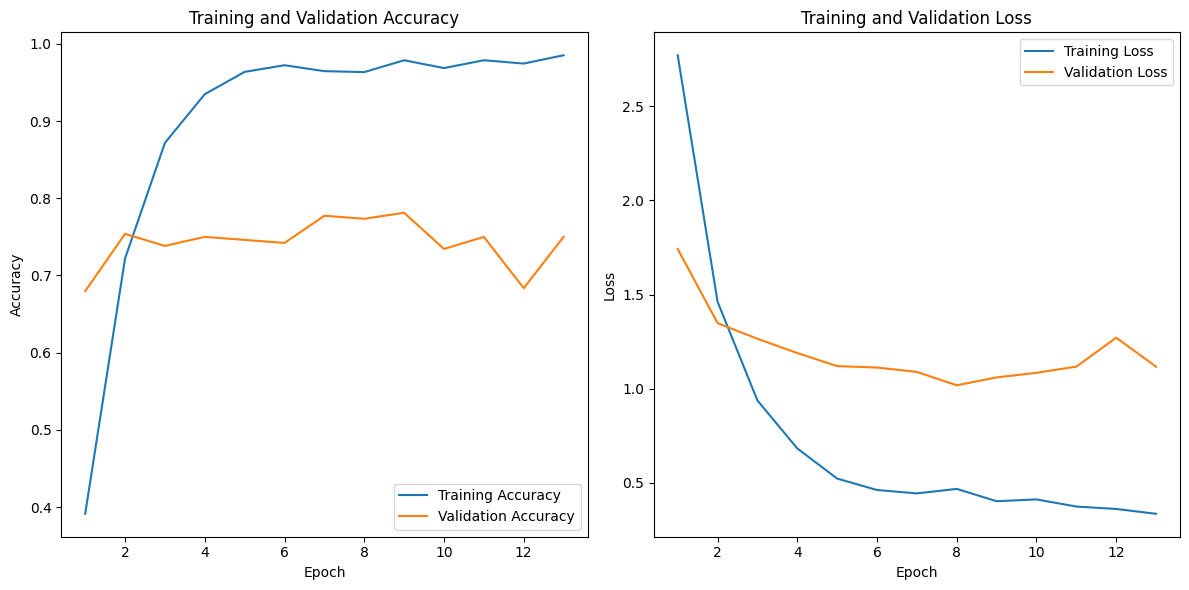

In [153]:
# Example of how to use this function, assuming you have a history object named 'history'
plot_training_history(history_simple_cnn)

3/3 [==============================] - 0s 164ms/step


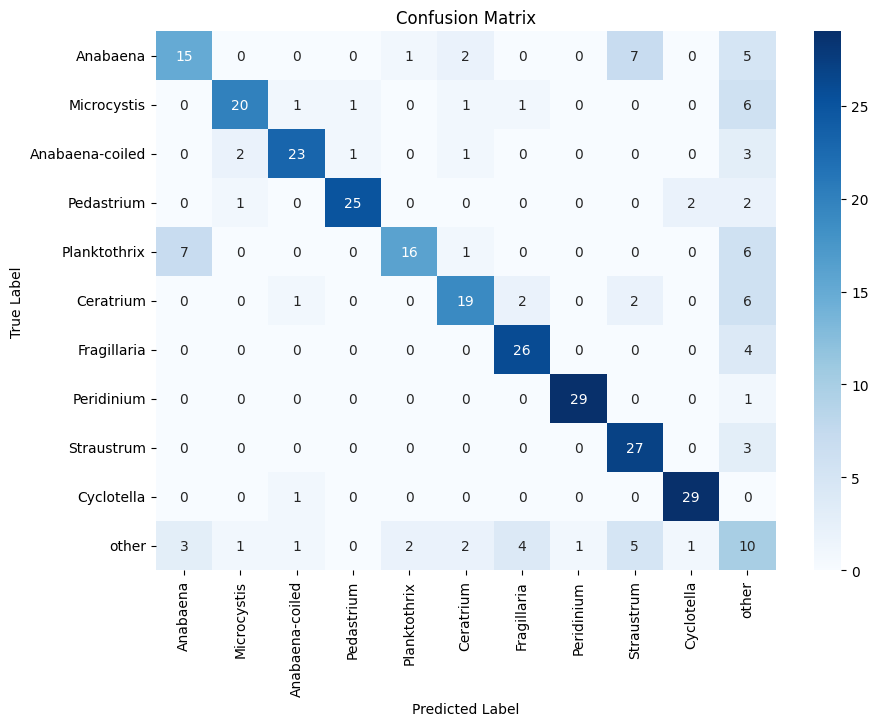


Class-wise Correct and Misclassified Counts:
Anabaena: Correct = 15, Misclassified = 15
Microcystis: Correct = 20, Misclassified = 10
Anabaena-coiled: Correct = 23, Misclassified = 7
Pedastrium: Correct = 25, Misclassified = 5
Planktothrix: Correct = 16, Misclassified = 14
Ceratrium: Correct = 19, Misclassified = 11
Fragillaria: Correct = 26, Misclassified = 4
Peridinium: Correct = 29, Misclassified = 1
Straustrum: Correct = 27, Misclassified = 3
Cyclotella: Correct = 29, Misclassified = 1
other: Correct = 10, Misclassified = 20

Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.50      0.55        30
          12       0.83      0.67      0.74        30
           2       0.85      0.77      0.81        30
          25       0.93      0.83      0.88        30
          27       0.84      0.53      0.65        30
          43       0.73      0.63      0.68        30
          44       0.79      0.87      0.83        30
       

In [154]:
# Usage example, assuming 'test_generator' is your test data generator and 'model' is your trained model
generate_classification_report(model, test_generator)

# Alexnet model

In [155]:
# Image dimensions and batch size
img_width, img_height = 227, 227  
batch_size = 128

# Directories
train_dir = '/kaggle/working/top-ten/train'
validation_dir = '/kaggle/working/top-ten/validation'
test_dir = '/kaggle/working/top-ten/test'


# Data generators for loading images
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 3381 images belonging to 11 classes.
Found 330 images belonging to 11 classes.
Found 330 images belonging to 11 classes.


In [156]:
model_alexnet = Sequential([
    Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(227, 227, 3)),
    MaxPooling2D(3, strides=2),
    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(3, strides=2),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(3, strides=2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])



lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9, staircase=True)
optimizer = Adam(learning_rate=lr_schedule)

model_alexnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit model
history_alexnet = model_alexnet.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


test_loss, test_accuracy = model_alexnet.evaluate(test_generator)

# Storing the last training loss and accuracy
train_loss = history_alexnet.history['loss'][-1]
train_accuracy = history_alexnet.history['accuracy'][-1]

# Print the results
print("Training Loss: {:.4f}, Training Accuracy: {:.2f}%".format(train_loss, train_accuracy * 100))
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy * 100))

Epoch 1/30
27/27 [==============================] - 15s 459ms/step - loss: 2.6068 - accuracy: 0.1520 - val_loss: 1.9809 - val_accuracy: 0.2121
Epoch 2/30
27/27 [==============================] - 8s 277ms/step - loss: 1.7509 - accuracy: 0.3375 - val_loss: 1.3596 - val_accuracy: 0.5424
Epoch 3/30
27/27 [==============================] - 8s 283ms/step - loss: 1.2170 - accuracy: 0.5552 - val_loss: 1.1020 - val_accuracy: 0.5727
Epoch 4/30
27/27 [==============================] - 8s 286ms/step - loss: 0.9041 - accuracy: 0.6723 - val_loss: 0.7028 - val_accuracy: 0.7333
Epoch 5/30
27/27 [==============================] - 8s 283ms/step - loss: 0.6663 - accuracy: 0.7696 - val_loss: 0.7007 - val_accuracy: 0.7697
Epoch 6/30
27/27 [==============================] - 8s 280ms/step - loss: 0.5238 - accuracy: 0.8249 - val_loss: 0.6158 - val_accuracy: 0.7788
Epoch 7/30
27/27 [==============================] - 8s 284ms/step - loss: 0.3940 - accuracy: 0.8577 - val_loss: 0.4624 - val_accuracy: 0.8303
Epoch

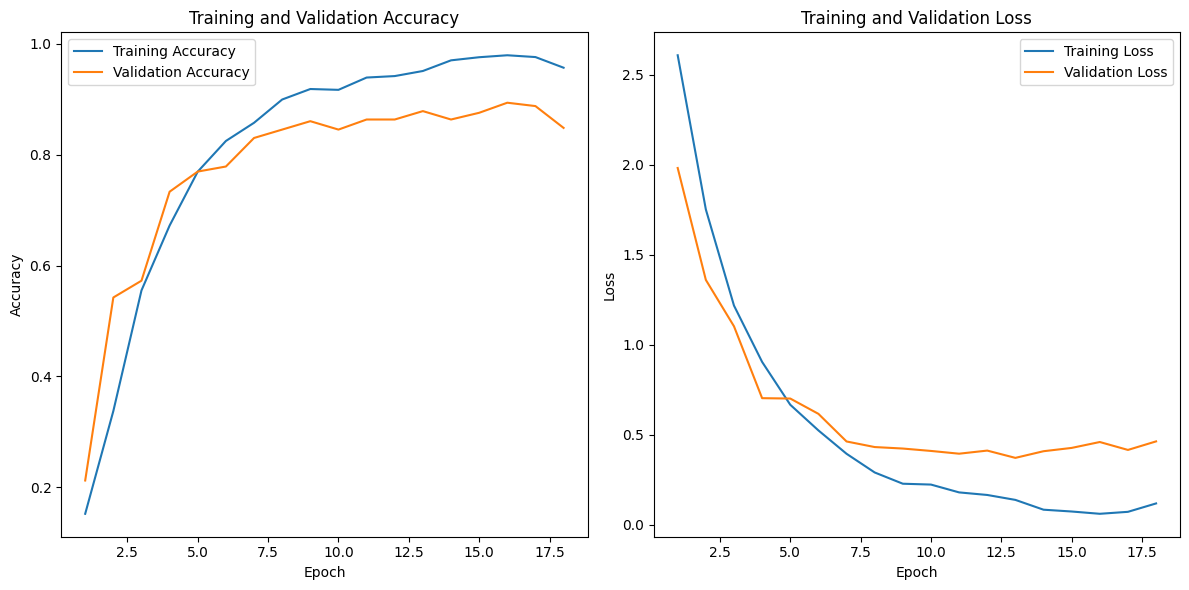

In [157]:
plot_training_history(history_alexnet)

3/3 [==============================] - 1s 298ms/step


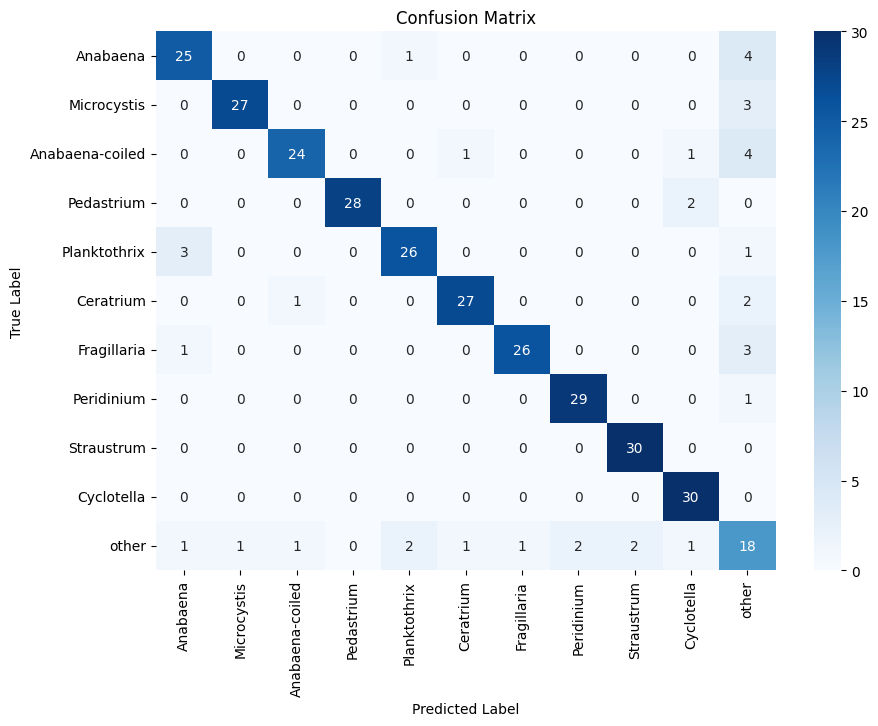


Class-wise Correct and Misclassified Counts:
Anabaena: Correct = 25, Misclassified = 5
Microcystis: Correct = 27, Misclassified = 3
Anabaena-coiled: Correct = 24, Misclassified = 6
Pedastrium: Correct = 28, Misclassified = 2
Planktothrix: Correct = 26, Misclassified = 4
Ceratrium: Correct = 27, Misclassified = 3
Fragillaria: Correct = 26, Misclassified = 4
Peridinium: Correct = 29, Misclassified = 1
Straustrum: Correct = 30, Misclassified = 0
Cyclotella: Correct = 30, Misclassified = 0
other: Correct = 18, Misclassified = 12

Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.83      0.83        30
          12       0.96      0.90      0.93        30
           2       0.92      0.80      0.86        30
          25       1.00      0.93      0.97        30
          27       0.90      0.87      0.88        30
          43       0.93      0.90      0.92        30
          44       0.96      0.87      0.91        30
          4

In [158]:
generate_classification_report(model_alexnet, test_generator)

# Lets try resnet

In [166]:
# Directories
train_dir = '/kaggle/working/top-ten/train'
validation_dir = '/kaggle/working/top-ten/validation'
test_dir = '/kaggle/working/top-ten/test'

# Image dimensions and batch size
img_width, img_height = 224, 224  # Change depending on your requirements
batch_size = 32

# Data generators for loading images
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 3381 images belonging to 11 classes.
Found 330 images belonging to 11 classes.
Found 330 images belonging to 11 classes.


In [167]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load ResNet50 base model without pretrained weights
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Adding custom Layers 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  
x = Dropout(0.5)(x)  # Adding Dropout
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Creating the final model 
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Make all layers trainable since we are training from scratch
for layer in resnet_model.layers:
    layer.trainable = True

# Compile the model with an appropriate optimizer and learning rate
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
resnet_history = resnet_model.fit(
    train_generator,
    epochs=50,  # Number of epochs may need to be increased since training from scratch
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = resnet_model.evaluate(test_generator)

# Print results
print("Training Loss: {:.4f}, Training Accuracy: {:.2f}%".format(resnet_history.history['loss'][-1], resnet_history.history['accuracy'][-1] * 100))
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy*100))


Epoch 1/50
106/106 [==============================] - 67s 357ms/step - loss: 9.4999 - accuracy: 0.2588 - val_loss: 9.8157 - val_accuracy: 0.0909
Epoch 2/50
106/106 [==============================] - 37s 350ms/step - loss: 3.4241 - accuracy: 0.5022 - val_loss: 8.4032 - val_accuracy: 0.0848
Epoch 3/50
106/106 [==============================] - 37s 353ms/step - loss: 1.9087 - accuracy: 0.6054 - val_loss: 4.6991 - val_accuracy: 0.1818
Epoch 4/50
106/106 [==============================] - 38s 354ms/step - loss: 1.2688 - accuracy: 0.6877 - val_loss: 8.9552 - val_accuracy: 0.0939
Epoch 5/50
106/106 [==============================] - 38s 355ms/step - loss: 0.9174 - accuracy: 0.7456 - val_loss: 2.4474 - val_accuracy: 0.4455
Epoch 6/50
106/106 [==============================] - 38s 354ms/step - loss: 0.8382 - accuracy: 0.7622 - val_loss: 7.6984 - val_accuracy: 0.1333
Epoch 7/50
106/106 [==============================] - 38s 355ms/step - loss: 0.7616 - accuracy: 0.7788 - val_loss: 5.9020 - val_ac

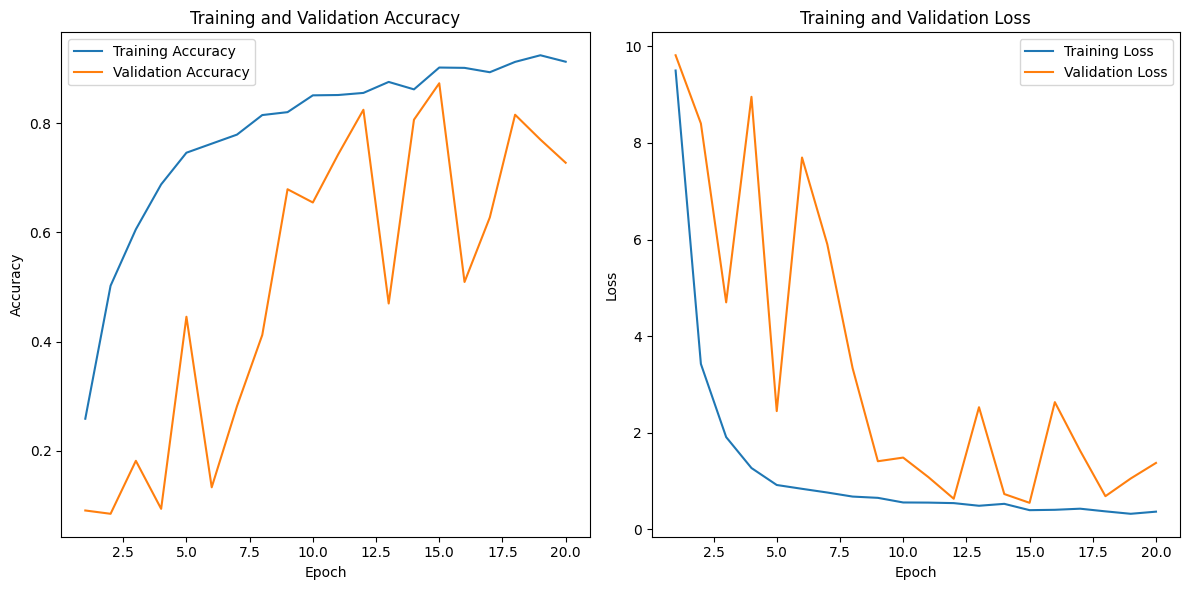

In [170]:
plot_training_history(resnet_history)

1/1 [==============================] - 0s 26ms/step


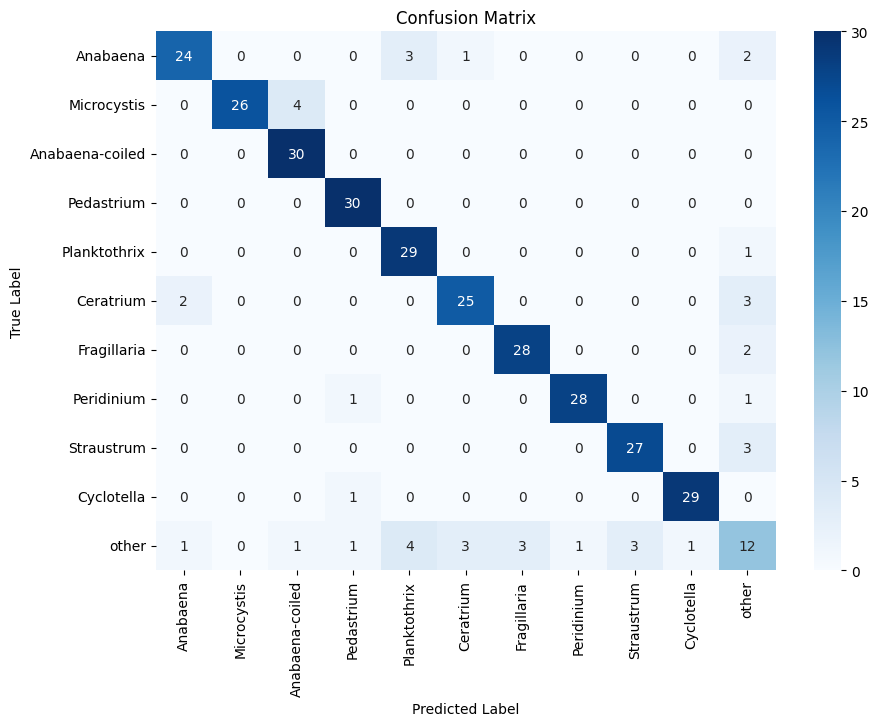


Class-wise Correct and Misclassified Counts:
Anabaena: Correct = 24, Misclassified = 6
Microcystis: Correct = 26, Misclassified = 4
Anabaena-coiled: Correct = 30, Misclassified = 0
Pedastrium: Correct = 30, Misclassified = 0
Planktothrix: Correct = 29, Misclassified = 1
Ceratrium: Correct = 25, Misclassified = 5
Fragillaria: Correct = 28, Misclassified = 2
Peridinium: Correct = 28, Misclassified = 2
Straustrum: Correct = 27, Misclassified = 3
Cyclotella: Correct = 29, Misclassified = 1
other: Correct = 12, Misclassified = 18

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.80      0.84        30
          12       1.00      0.87      0.93        30
           2       0.86      1.00      0.92        30
          25       0.91      1.00      0.95        30
          27       0.81      0.97      0.88        30
          43       0.86      0.83      0.85        30
          44       0.90      0.93      0.92        30
          4

In [171]:
generate_classification_report(resnet_model, test_generator)